 # ---> **LIBRERÍAS** <---

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import random

from keras.models import Sequential
from keras.layers import Dense, Flatten

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ---> **IMPORTAR DATASETS** <---

In [95]:
lotes = 64
semilla = 33

nombre_dataset = 'cats20_probarV2'

train_directory = f'C:/Users/aleja/Downloads/{nombre_dataset}/TRAINING'
validation_directory = f'C:/Users/aleja/Downloads/{nombre_dataset}/VALIDATION'
test_directory = f'C:/Users/aleja/Downloads/{nombre_dataset}/TESTING'

In [96]:
def importarDatasets(dimensiones: tuple):
    
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                train_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=dimensiones,
                batch_size=lotes,
                seed=semilla
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                validation_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=dimensiones,
                batch_size=lotes,
                seed=semilla
    )

    testing_dataset = tf.keras.utils.image_dataset_from_directory(
            test_directory,
            labels='inferred',
            label_mode='categorical',
            image_size=dimensiones,
            batch_size=lotes,
            seed=semilla
    )
    
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    return train_dataset, validation_dataset, testing_dataset, num_classes

 # ---> **MODELO4: EfficientNetB2 con GPU** <---

In [97]:
from keras.applications import EfficientNetB2
from keras.layers import Input

dimensionesModelo4 = (224, 224)
train_dataset, validation_dataset, testing_dataset, num_classes = importarDatasets(dimensionesModelo4)

dimension_foto = dimensionesModelo4[0]

model4 = Sequential()
model4.add(Input(shape=(dimension_foto, dimension_foto, 3)))

efficientNetB2 = EfficientNetB2(weights='imagenet', include_top=False)
efficientNetB2.trainable=False
model4.add(efficientNetB2)

model4.add(Flatten())
model4.add(Dense(64,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))

model4.build(input_shape=(32, dimension_foto, dimension_foto, 3))
model4.summary()

Found 10915 files belonging to 31 classes.
Found 3101 files belonging to 31 classes.
Found 1539 files belonging to 31 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 64)                4415552   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 31)                2015      
                                                                 
Total params: 12,190,296
Trainable params: 4,421,727
Non-trai

In [98]:
import time

model4.compile(
  optimizer=tf.keras.optimizers.SGD(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy']
)

inicio = time.time()

history = model4.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=15,
                    verbose=1,
                    shuffle=True,
)

fin = time.time()
tiempo = fin - inicio
minutos = int(tiempo/60)
print(f'Tiempo entrenamiento: {minutos} min {round(tiempo-60*minutos,2)} s')

Epoch 1/15


171/171 [==============================] - 34s 164ms/step - loss: 1.5368 - accuracy: 0.5746 - val_loss: 0.9882 - val_accuracy: 0.7046
Epoch 2/15
171/171 [==============================] - 22s 124ms/step - loss: 0.5993 - accuracy: 0.8172 - val_loss: 0.6654 - val_accuracy: 0.7843
Epoch 3/15
171/171 [==============================] - 21s 121ms/step - loss: 0.3359 - accuracy: 0.8984 - val_loss: 0.5355 - val_accuracy: 0.8346
Epoch 4/15
171/171 [==============================] - 21s 121ms/step - loss: 0.2134 - accuracy: 0.9379 - val_loss: 0.4603 - val_accuracy: 0.8636
Epoch 5/15
171/171 [==============================] - 21s 121ms/step - loss: 0.1317 - accuracy: 0.9657 - val_loss: 0.4451 - val_accuracy: 0.8652
Epoch 6/15
171/171 [==============================] - 21s 121ms/step - loss: 0.0961 - accuracy: 0.9771 - val_loss: 0.4841 - val_accuracy: 0.8584
Epoch 7/15
171/171 [==============================] - 21s 120ms/step - loss: 0.0714 - accuracy: 0.9852 - val_loss: 0.4321 - val_accuracy: 0.8

 # ---> **RESULTADOS** <---

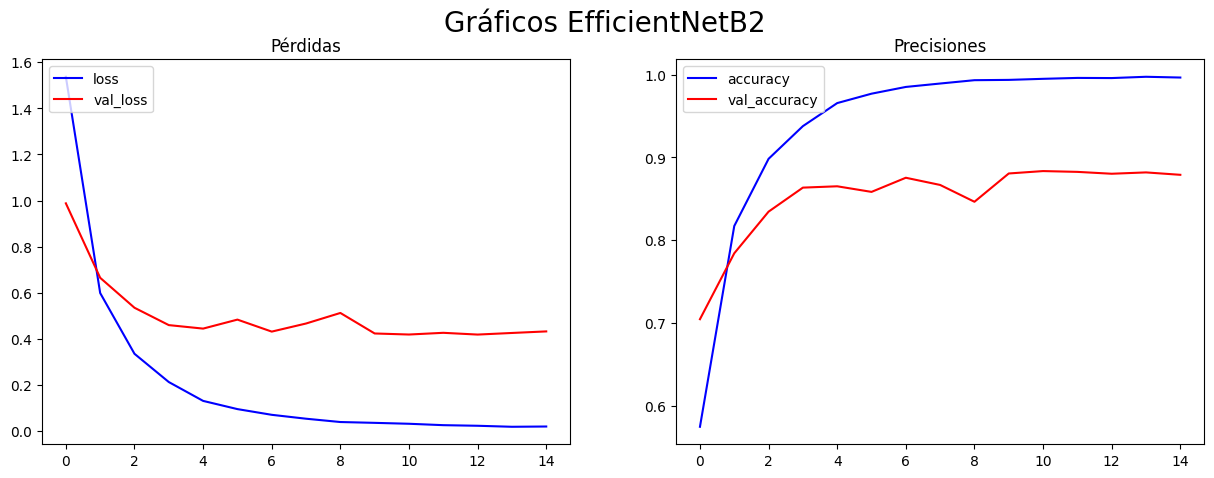

25/25 [==============================] - 3s 105ms/step - loss: 0.4498 - accuracy: 0.8759
***** Test loss:  0.44978809356689453
***** Test accuracy:  0.8758934140205383


In [99]:
fig = plt.figure(figsize=(15,5))

# Primera posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,1)
plt.title(label='Pérdidas')
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc="upper left")

# Segunda posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,2)
plt.title(label='Precisiones')
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.legend(loc="upper left")

fig.suptitle('Gráficos EfficientNetB2', fontsize=20)
plt.show()
#---------------------------------
test_loss, test_acc = model4.evaluate(testing_dataset, verbose=1)
print('***** Test loss: ', test_loss)
print('***** Test accuracy: ', test_acc)

 # ---> **PREDECIR IMÁGENES** <---

In [100]:
def predecir_imagenes(numFotosPredecir: int):
  directorio_base = test_directory
  lista_razas = os.listdir(directorio_base)

  figura = plt.figure(figsize=(20,10))
  class_names = os.listdir(train_directory)

  LISTA_NP_ARRAYS = []
  LISTA_RAZAS = []

  for i in range(numFotosPredecir): # nº de fotos a predecir
    raza_escogida = random.choice(lista_razas)
    LISTA_RAZAS.append(raza_escogida)
    directorio_raza = f'{directorio_base}/{raza_escogida}'
    nombre_imagen = random.choice(os.listdir(directorio_raza))
    print(directorio_raza, '::', nombre_imagen)

    imagen = Image.open(f'{directorio_raza}/{nombre_imagen}')
    imagen = imagen.resize(dimensionesModelo4)
    imagen = np.array(imagen)
    LISTA_NP_ARRAYS.append(imagen) # añado el numpy array
    imagen = np.expand_dims(imagen, axis=0)

    prediction_array = model4(imagen)  
    index_predicted = np.argmax(prediction_array)
    label_predicted = class_names[index_predicted]
    #------------------------------------------------------
    figura.add_subplot(2,3,i+1)
    plt.imshow(LISTA_NP_ARRAYS[i])
    plt.title(f"{LISTA_RAZAS[i]}, predicted: {label_predicted}")
  
  plt.show()

C:/Users/aleja/Downloads/cats20_probarV2/TESTING/Egyptian Mau :: Egyptian Mau_264.jpg
C:/Users/aleja/Downloads/cats20_probarV2/TESTING/Manx :: Manx_23.jpg


C:/Users/aleja/Downloads/cats20_probarV2/TESTING/American Curl :: American Curl_424.jpg
C:/Users/aleja/Downloads/cats20_probarV2/TESTING/Calico :: Calico_173.jpg
C:/Users/aleja/Downloads/cats20_probarV2/TESTING/Siamese :: Siamese_230.jpg
C:/Users/aleja/Downloads/cats20_probarV2/TESTING/Birman :: Birman_37.jpg


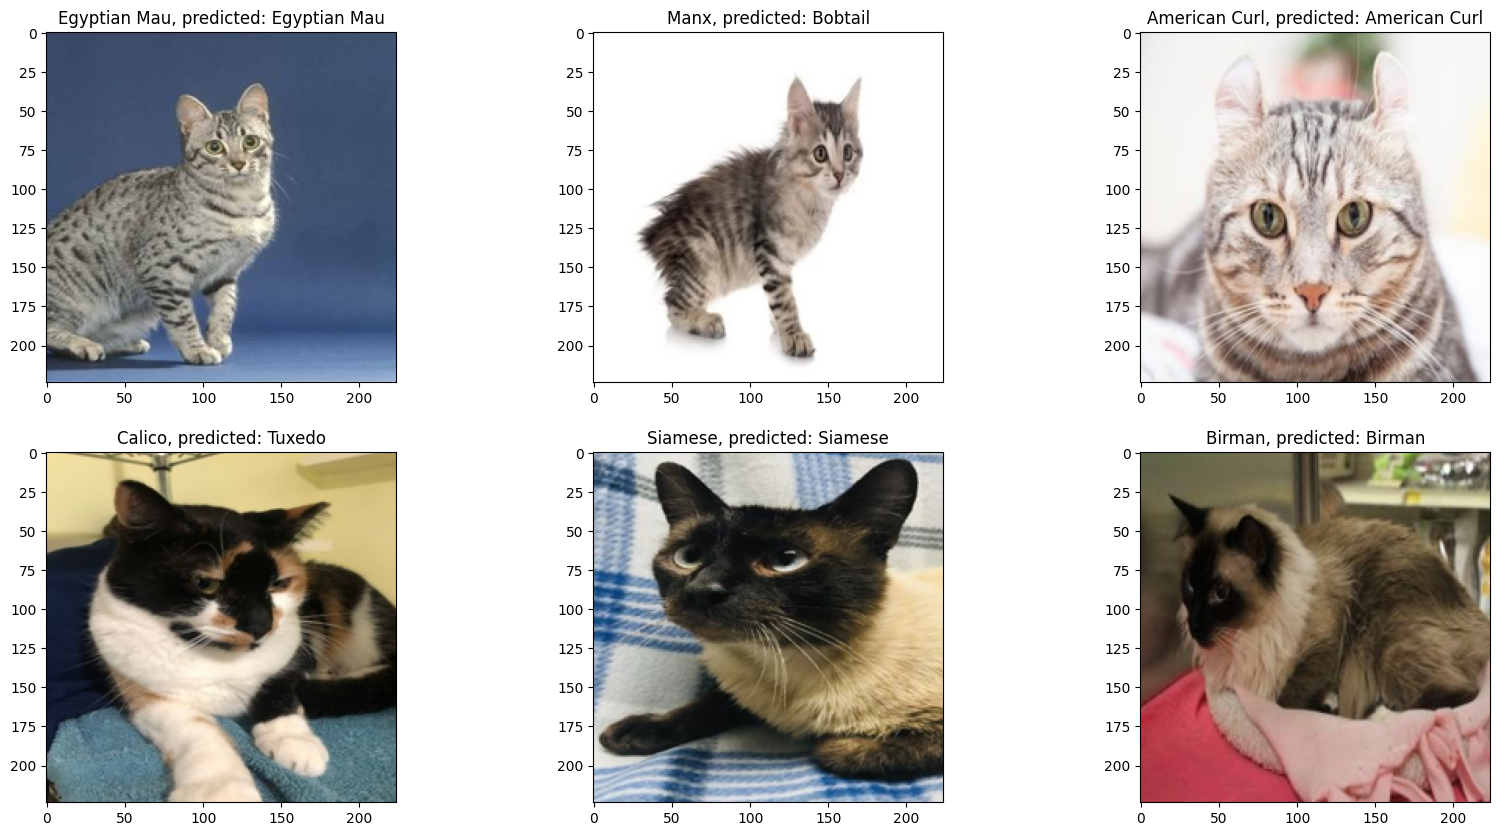

In [164]:
predecir_imagenes(6)

# ---> **IMÁGENES A MANO** <---

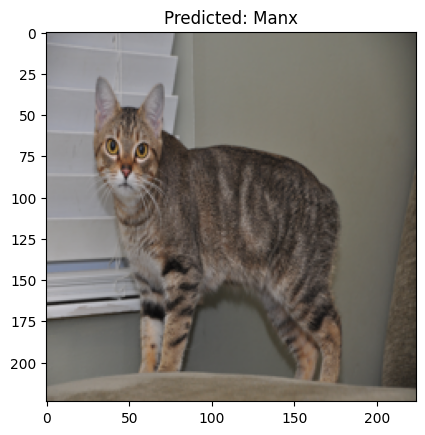

In [48]:
imagen22 = Image.open('AAmanx.jpg')
imagen22 = imagen22.resize(dimensionesModelo4)
imagen22 = np.array(imagen22)
auxiliar = imagen22
imagen22 = np.expand_dims(imagen22, axis=0)

class_names = os.listdir(test_directory)

prediction_array = model4(imagen22) # model.predict()
index_predicted = np.argmax(prediction_array[0]) # [[...]]
label_predicted = class_names[index_predicted]

plt.imshow(auxiliar)
plt.title(f'Predicted: {label_predicted}')
plt.show()

# ---> **MATRIZ DE CONFUSIÓN BUENA** <---

In [4]:
model = tf.keras.models.load_model('MendozasNet.keras')

In [157]:
test_directory = f'C:/Users/aleja/Downloads/{nombre_dataset}/TESTING'
testing_dataset = tf.keras.utils.image_dataset_from_directory(
            test_directory,
            labels='inferred',
            label_mode='categorical',
            image_size=(224,224),
            batch_size=lotes,
            seed=semilla
    )

Found 1539 files belonging to 31 classes.


In [158]:
predicted_labels = []
true_labels = []

datasetIterator = list(testing_dataset.as_numpy_iterator()) # 25 batches de 64

for imagenes, labels in datasetIterator: # datasetIterator: lista de 25 tuplas, cada tupla con 64 imágenes y 64 labels
    true_labels += list(np.argmax(labels, axis=1)) # OK

    lote = imagenes/255
    predicciones = model4.predict(imagenes)
    predicted_labels += list(np.argmax(predicciones, axis=1))    

1/1 [==============================] - 0s 20ms/step


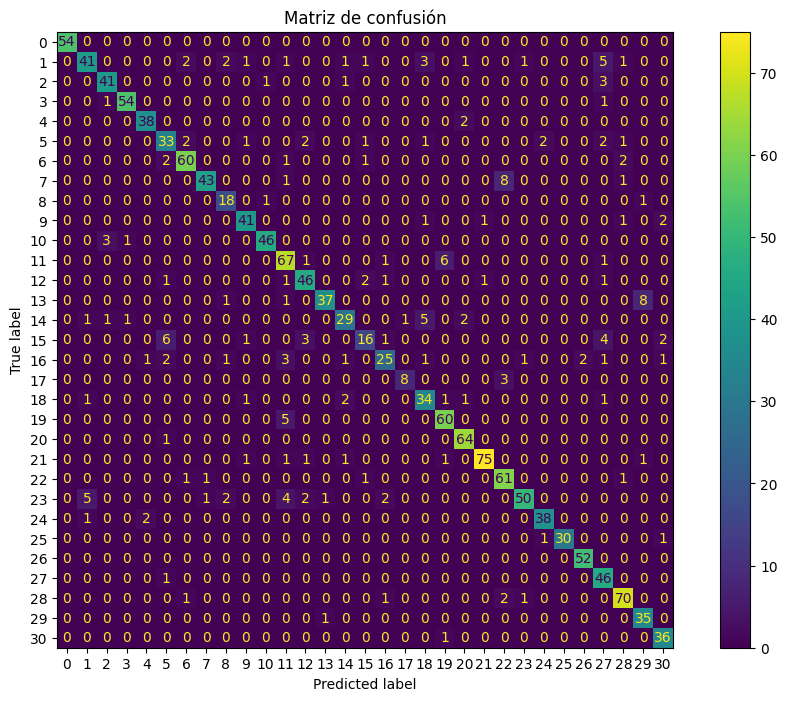

In [160]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

matrix = confusion_matrix(true_labels, predicted_labels)

figura, axes = plt.subplots(figsize=(12, 8))
confusionMatrix = ConfusionMatrixDisplay(matrix)  # display_labels=lista_razas_test
confusionMatrix.plot(ax=axes, cmap='viridis')
confusionMatrix.ax_.set_title("Matriz de confusión")

plt.show()

***

# ---> **GUARDAR Y CARGAR MODELO** <---

In [161]:
import keras

# model4.save("Mendoza_sNet.keras")

instancia = keras.models.load_model("MendozasNet88.keras")

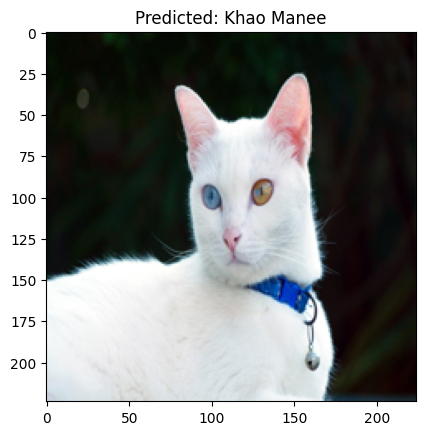

In [162]:
imagen22 = Image.open('AAkhao-manee.jpg')
# imagen22 = imagen22.resize(dimensionesModelo4)
imagen22 = np.array(imagen22)
auxiliar = imagen22
imagen22 = np.expand_dims(imagen22, axis=0)

class_names = os.listdir(test_directory)

prediction_array = instancia(imagen22) # model.predict()
index_predicted = np.argmax(prediction_array[0]) # [[...]]
label_predicted = class_names[index_predicted]

plt.imshow(auxiliar)
plt.title(f'Predicted: {label_predicted}')
plt.show()